In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
train_data = pd.read_csv('core-data/train.csv')

In [42]:
train_data.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100


In [43]:
# Create a new column "remaining_year" to understand the remaining years of the flat
train_data[['rent_approved_year','rent_approved_month']] = train_data['rent_approval_date'].str.split('-', expand=True)
remaining_year = 99 - (train_data['rent_approved_year'].astype(int) - train_data['lease_commence_date'])
train_data['remaining_year'] = remaining_year
train_data['rent_approved_month'] = train_data['rent_approved_month'].astype(int)

In [44]:
# Unified the different format of values
train_data['flat_type'] = train_data['flat_type'].str.replace(' ', '-')
train_data['flat_type'].unique()

array(['3-room', '4-room', 'executive', '5-room', '2-room'], dtype=object)

In [45]:
train_data.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent,rent_approved_year,rent_approved_month,remaining_year
0,2021-09,jurong east,257,Jurong East Street 24,3-room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600,2021,9,61
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250,2022,5,55
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900,2022,10,48
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850,2021,8,71
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100,2022,11,49


In [46]:
# Drop the following columns
# Since 'town' has a high correlation with 'planning_area', we dropped 'town'.
train_data = train_data.drop("town", axis=1)
# Since 'rent_approval_date' was splitted into numerical variables like 'rent_approved_year' & 'rent_approved_month', we dropped it. 
train_data = train_data.drop("rent_approval_date", axis=1)
# Since 'street_name' & 'block' has a lot of patterns when encoding, we dropped them.
train_data = train_data.drop("street_name", axis=1)
train_data = train_data.drop("block", axis=1)
# Since these columns have only one value, we dropped them.
train_data = train_data.drop("furnished", axis=1)
train_data = train_data.drop("elevation", axis=1)

In [47]:
# Create a "monthly_price_per_sqm" column to represent a more precise indication of monthly price
train_data['monthly_price_per_sqm'] = train_data['monthly_rent'] / train_data['floor_area_sqm']

In [48]:
# Create new features to calculate the average rent according to each specific category
train_data['yearly_avg_rent'] = train_data.groupby('rent_approved_year')['monthly_rent'].transform('mean')
train_data['monthly_avg_rent_by_region'] = train_data.groupby('region')['monthly_rent'].transform('mean')
train_data['monthly_avg_rent_by_subzone']= train_data.groupby('subzone')['monthly_rent'].transform('mean')
train_data['monthly_avg_rent_by_planning_area'] = train_data.groupby('planning_area')['monthly_rent'].transform('mean')
train_data['monthly_avg_rent_by_flat_model'] = train_data.groupby('flat_model')['monthly_rent'].transform('mean')

In [49]:
train_data['monthly_avg_rent_per_sqm_by_region'] = train_data.groupby('region')['monthly_price_per_sqm'].transform('mean')
train_data['monthly_avg_rent_per_sqm_by_subzone'] = train_data.groupby('subzone')['monthly_price_per_sqm'].transform('mean')
train_data['monthly_avg_rent_per_sqm_by_planning_area'] = train_data.groupby('planning_area')['monthly_price_per_sqm'].transform('mean')
train_data['monthly_avg_rent_per_sqm_by_flat_model'] = train_data.groupby('flat_model')['monthly_price_per_sqm'].transform('mean')

In [50]:
# This code snippet describes a process where labels are assigned to different regions in ascending order (starting from 1).
# The labeling strategy is significant because the smaller the label number, the higher the corresponding average rent is.
# In other words, labels are assigned based on the average rent of each region, with higher rents receiving lower-numbered labels.
# Additionally, to maintain consistency, the same labels are applied to the same values in the test data.
# This is why both the original values and the label columns are preserved in the dataset.
# The code also shows how numerical encoding is applied to various features such as flat type,
# flat model, planning area, and region. Grouping by each category and calculating the mean average rent,
# followed by sorting these averages in descending order, allows for the mapping of each category to its label number.
# The resulting dictionaries (region_to_label, subzone_to_label, etc.) are then used to transform the categorical data
# into numerical labels within the training data.

ordered_regions = train_data.groupby('region')['monthly_avg_rent_by_region'].mean().sort_values(ascending=False).index
ordered_subzone = train_data.groupby('subzone')['monthly_avg_rent_by_subzone'].mean().sort_values(ascending=False).index
ordered_planning_area = train_data.groupby('planning_area')['monthly_avg_rent_by_planning_area'].mean().sort_values(ascending=False).index
ordered_flat_model = train_data.groupby('flat_model')['monthly_avg_rent_by_flat_model'].mean().sort_values(ascending=False).index

region_to_label = {region: i + 1 for i, region in enumerate(ordered_regions)}
subzone_to_label = {region: i + 1 for i, region in enumerate(ordered_subzone)}
planning_area_to_label = {region: i + 1 for i, region in enumerate(ordered_planning_area)}
flat_model_to_label = {region: i + 1 for i, region in enumerate(ordered_flat_model)}

train_data['region_label'] = train_data['region'].map(region_to_label)
train_data['subzone_label'] = train_data['subzone'].map(subzone_to_label)
train_data['planning_area_label'] = train_data['planning_area'].map(planning_area_to_label)
train_data['flat_model_label'] = train_data['flat_model'].map(flat_model_to_label)

In [51]:
train_data.head(20)

,flat_type,flat_model,floor_area_sqm,lease_commence_date,latitude,longitude,subzone,planning_area,region,monthly_rent,...,monthly_avg_rent_by_planning_area,monthly_avg_rent_by_flat_model,monthly_avg_rent_per_sqm_by_region,monthly_avg_rent_per_sqm_by_subzone,monthly_avg_rent_per_sqm_by_planning_area,monthly_avg_rent_per_sqm_by_flat_model,region_label,subzone_label,planning_area_label,flat_model_label
0,3-room,new generation,67.0,1983,1.344518,103.738630,yuhua east,jurong east,west region,1600,...,2595.146199,2369.965462,27.233545,29.738220,27.915301,31.060362,3,92,16,18
1,4-room,new generation,92.0,1978,1.330186,103.938717,bedok north,bedok,east region,2250,...,2438.227223,2369.965462,27.057755,30.937463,29.456489,31.060362,2,136,27,18
2,3-room,improved,67.0,1971,1.332242,103.845643,toa payoh central,toa payoh,central region,1900,...,2516.680515,2636.211052,33.891545,33.034791,32.040421,27.884012,1,36,20,13
3,executive,apartment,149.0,1993,1.370239,103.962894,pasir ris drive,pasir ris,east region,2850,...,2686.857477,2878.725962,27.057755,21.639655,22.531163,20.313390,2,66,9,11
4,3-room,improved,68.0,1972,1.320502,103.863341,bendemeer,kallang,central region,2100,...,2702.635659,2636.211052,33.891545,34.378542,33.885155,27.884012,1,37,8,13
5,executive,premium apartment,130.0,2001,1.387847,103.764249,saujana,bukit panjang,west region,2300,...,2493.746111,2709.678998,27.233545,23.436378,24.788973,26.057876,3,67,23,12
6,5-room,premium apartment,110.0,2005,1.388997,103.875148,fernvale,sengkang,north-east region,2100,...,2622.233325,2709.678998,27.838756,29.356150,26.091754,26.057876,4,75,15,12
7,3-room,new generation,67.0,1978,1.366048,103.838123,shangri-la,ang mo kio,north-east region,2300,...,2416.700057,2369.965462,27.838756,30.628670,30.492336,31.060362,4,138,28,18
8,4-room,simplified,84.0,1987,1.344279,103.855556,bishan east,bishan,central region,2100,...,2867.049408,2464.689064,33.891545,30.832871,29.614409,32.036721,1,24,5,15
9,5-room,premium apartment,112.0,2003,1.392832,103.910620,punggol field,punggol,north-east region,2100,...,2665.555556,2709.678998,27.838756,24.535033,27.696387,26.057876,4,68,10,12


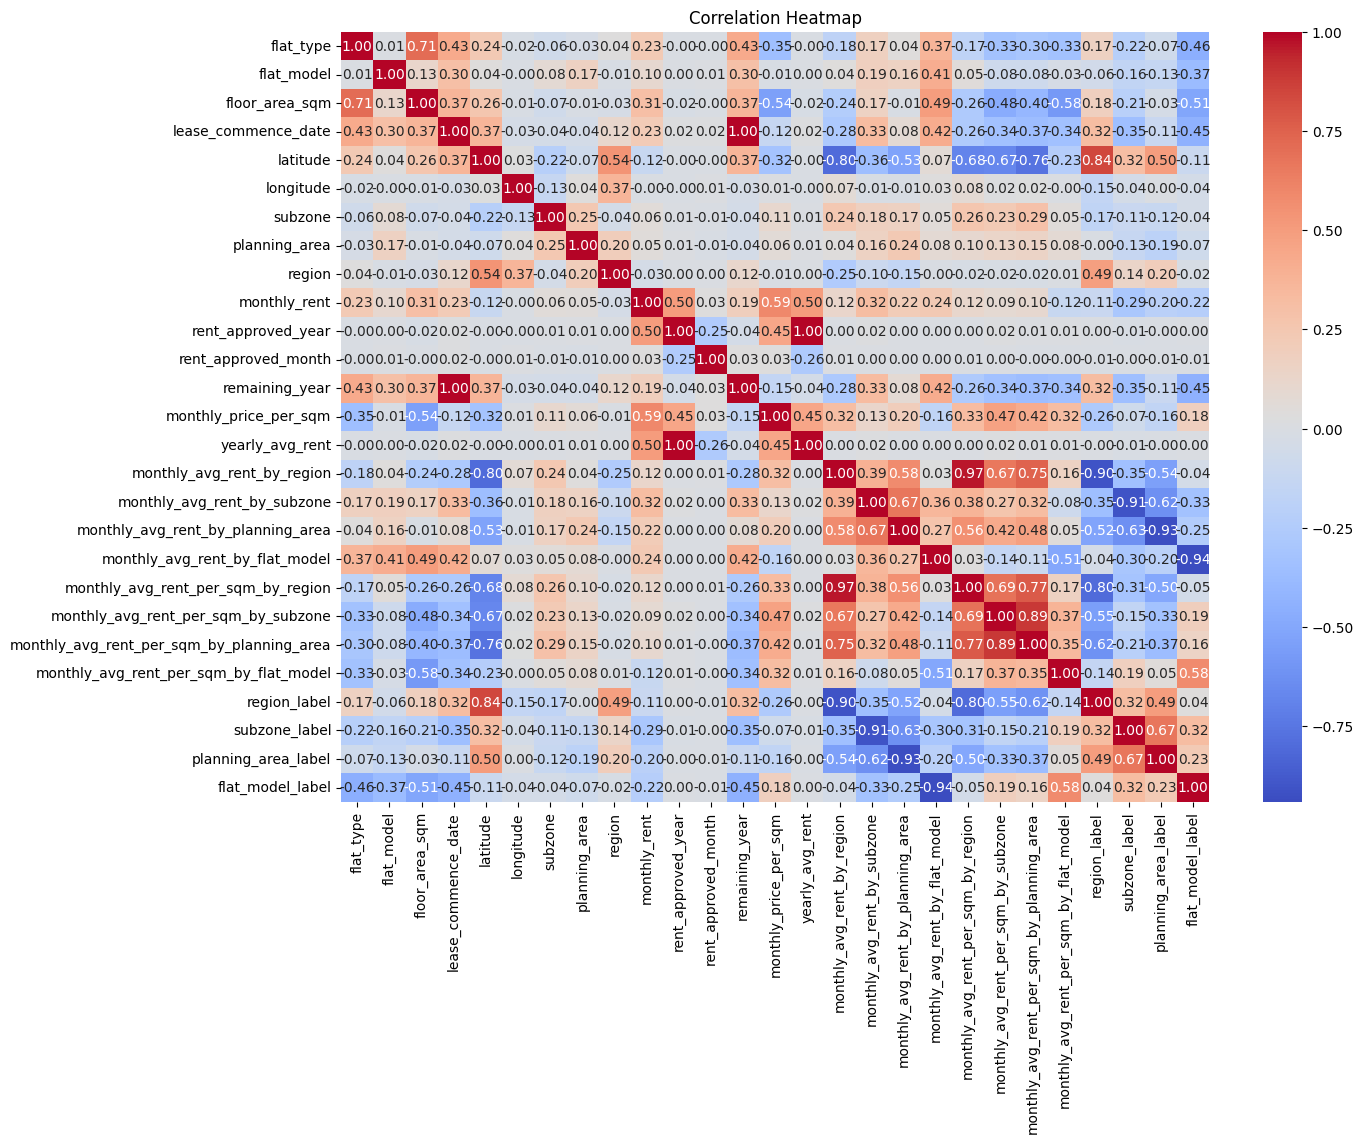

In [52]:
# Encode categorical variables to check the correlation between features
data_for_cor_check = train_data.copy()
data_for_cor_check['flat_type'] =  pd.factorize(data_for_cor_check['flat_type'])[0] + 1
data_for_cor_check['flat_model'] =  pd.factorize(data_for_cor_check['flat_model'])[0] + 1
data_for_cor_check['subzone'] =  pd.factorize(data_for_cor_check['subzone'])[0] + 1
data_for_cor_check['planning_area'] =  pd.factorize(data_for_cor_check['planning_area'])[0] + 1
data_for_cor_check['region'] =  pd.factorize(data_for_cor_check['region'])[0] + 1

# Check the correlation matrix between features
correlation_matrix = data_for_cor_check.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [53]:
# Since these columns have high correlations for each other(0.71, 1.00), we dropped them.
train_data = train_data.drop("flat_type", axis=1)
train_data = train_data.drop("lease_commence_date", axis=1)

In [54]:
train_data.head()

,flat_model,floor_area_sqm,latitude,longitude,subzone,planning_area,region,monthly_rent,rent_approved_year,rent_approved_month,...,monthly_avg_rent_by_planning_area,monthly_avg_rent_by_flat_model,monthly_avg_rent_per_sqm_by_region,monthly_avg_rent_per_sqm_by_subzone,monthly_avg_rent_per_sqm_by_planning_area,monthly_avg_rent_per_sqm_by_flat_model,region_label,subzone_label,planning_area_label,flat_model_label
0,new generation,67.0,1.344518,103.738630,yuhua east,jurong east,west region,1600,2021,9,...,2595.146199,2369.965462,27.233545,29.738220,27.915301,31.060362,3,92,16,18
1,new generation,92.0,1.330186,103.938717,bedok north,bedok,east region,2250,2022,5,...,2438.227223,2369.965462,27.057755,30.937463,29.456489,31.060362,2,136,27,18
2,improved,67.0,1.332242,103.845643,toa payoh central,toa payoh,central region,1900,2022,10,...,2516.680515,2636.211052,33.891545,33.034791,32.040421,27.884012,1,36,20,13
3,apartment,149.0,1.370239,103.962894,pasir ris drive,pasir ris,east region,2850,2021,8,...,2686.857477,2878.725962,27.057755,21.639655,22.531163,20.313390,2,66,9,11
4,improved,68.0,1.320502,103.863341,bendemeer,kallang,central region,2100,2022,11,...,2702.635659,2636.211052,33.891545,34.378542,33.885155,27.884012,1,37,8,13


In [55]:
# Since I need to use some categorical columns within train data for cleaning test data.
# I outputted train data for test data preprocessing
train_data.to_csv('train-data-for-test.csv')

In [56]:
# Cleaned all unnecessary categorical columns for train data
train_data = train_data.drop("monthly_price_per_sqm", axis=1)
train_data['region'] = train_data['region_label']
train_data['subzone'] = train_data['subzone_label']
train_data['planning_area'] = train_data['planning_area_label']
train_data['flat_model'] = train_data['flat_model_label']
train_data = train_data.drop("region_label", axis=1)
train_data = train_data.drop("subzone_label", axis=1)
train_data = train_data.drop("planning_area_label", axis=1)
train_data = train_data.drop("flat_model_label", axis=1)
train_data.to_csv('train-data-cleaned.csv')
train_data.head()

# Data Cleaning Part Finished

,flat_model,floor_area_sqm,latitude,longitude,subzone,planning_area,region,monthly_rent,rent_approved_year,rent_approved_month,remaining_year,yearly_avg_rent,monthly_avg_rent_by_region,monthly_avg_rent_by_subzone,monthly_avg_rent_by_planning_area,monthly_avg_rent_by_flat_model,monthly_avg_rent_per_sqm_by_region,monthly_avg_rent_per_sqm_by_subzone,monthly_avg_rent_per_sqm_by_planning_area,monthly_avg_rent_per_sqm_by_flat_model
0,18,67.0,1.344518,103.738630,92,16,3,1600,2021,9,61,2225.773817,2569.167537,2542.158516,2595.146199,2369.965462,27.233545,29.738220,27.915301,31.060362
1,18,92.0,1.330186,103.938717,136,27,2,2250,2022,5,55,2651.014066,2570.667785,2360.371046,2438.227223,2369.965462,27.057755,30.937463,29.456489,31.060362
2,13,67.0,1.332242,103.845643,36,20,1,1900,2022,10,48,2651.014066,2737.201353,2808.893871,2516.680515,2636.211052,33.891545,33.034791,32.040421,27.884012
3,11,149.0,1.370239,103.962894,66,9,2,2850,2021,8,71,2225.773817,2570.667785,2610.338573,2686.857477,2878.725962,27.057755,21.639655,22.531163,20.313390
4,13,68.0,1.320502,103.863341,37,8,1,2100,2022,11,49,2651.014066,2737.201353,2793.525180,2702.635659,2636.211052,33.891545,34.378542,33.885155,27.884012
